# Implement DDPM for image generation using Fashion-MNIST

This code implements the main loop for the diffusion models in Module3

In [99]:
# Imports

import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm.auto import tqdm


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print(f"Torch version {torch.__version__}")


Device: cuda
Torch version 2.3.1+cu118


### Load Fashion-MNIST dataset

In [ ]:
ds_fn = FashionMNIST
batch_size = 128

transform = Compose([ToTensor(), Lambda(lambda x: x * 2 - 1)])

dataset = ds_fn(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("Dataset has been loaded.")

Dataset has been loaded.


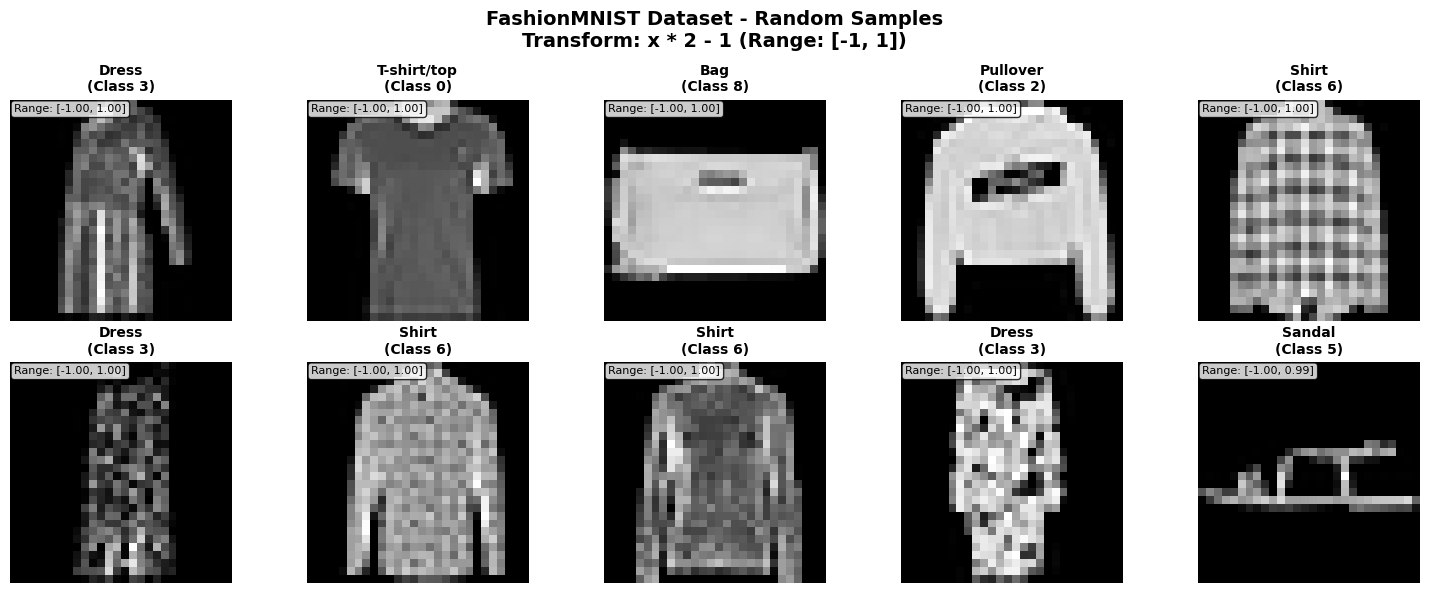

Dataset Statistics:
Total samples: 60000
Number of classes: 10
Image shape: torch.Size([1, 28, 28])
Transform applied: x * 2 - 1
Expected pixel range: [-1, 1]
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Actual pixel range in samples: [-1.000, 1.000]



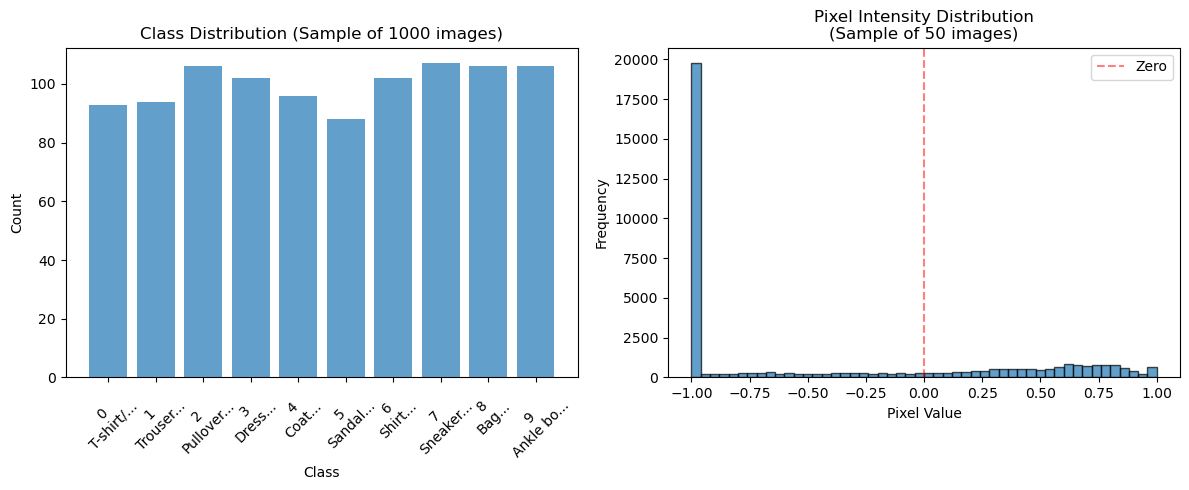

In [38]:
# Visualize dataset

# FashionMNIST class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

def visualize_random_samples(dataset, num_samples=10, figsize=(15, 6)):
    """
    Visualize random samples from the FashionMNIST dataset
    """
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Create subplot
    fig, axes = plt.subplots(2, 5, figsize=figsize)
    fig.suptitle('FashionMNIST Dataset - Random Samples\nTransform: x * 2 - 1 (Range: [-1, 1])', 
                 fontsize=14, fontweight='bold')
    
    for i, idx in enumerate(random_indices):
        # Get image and label
        image, label = dataset[idx]
        
        # Convert tensor to numpy and squeeze to remove channel dimension
        # Note: image values are in range [-1, 1] due to transform
        img_np = image.squeeze().numpy()
        
        # Calculate subplot position
        row = i // 5
        col = i % 5
        
        # Display image
        axes[row, col].imshow(img_np, cmap='gray', vmin=-1, vmax=1)
        axes[row, col].set_title(f'{class_names[label]}\n(Class {label})', 
                                fontsize=10, fontweight='bold')
        axes[row, col].axis('off')
        
        # Add pixel value range info
        axes[row, col].text(0.02, 0.98, f'Range: [{img_np.min():.2f}, {img_np.max():.2f}]',
                           transform=axes[row, col].transAxes, 
                           fontsize=8, verticalalignment='top',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


def analyze_dataset_statistics(dataset):
    """
    Analyze and visualize dataset statistics
    """
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Image shape: {dataset[0][0].shape}")
    print(f"Transform applied: x * 2 - 1")
    print(f"Expected pixel range: [-1, 1]")
    print(f"Class names: {class_names}")
    
    # Sample a few images to check actual pixel range
    sample_images = [dataset[i][0] for i in range(0, min(100, len(dataset)), 10)]
    min_vals = [img.min().item() for img in sample_images]
    max_vals = [img.max().item() for img in sample_images]
    
    print(f"Actual pixel range in samples: [{min(min_vals):.3f}, {max(max_vals):.3f}]")
    print()
    
    # Class distribution (sample 1000 items)
    sample_size = min(1000, len(dataset))
    labels = [dataset[i][1] for i in np.random.choice(len(dataset), sample_size, replace=False)]
    
    plt.figure(figsize=(12, 5))
    
    # Class distribution
    plt.subplot(1, 2, 1)
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, alpha=0.7)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Class Distribution (Sample of {sample_size} images)')
    plt.xticks(unique, [f'{i}\n{class_names[i][:8]}...' for i in unique], rotation=45)
    
    # Pixel intensity distribution
    plt.subplot(1, 2, 2)
    sample_pixels = np.concatenate([dataset[i][0].numpy().flatten() 
                                   for i in np.random.choice(len(dataset), 50, replace=False)])
    plt.hist(sample_pixels, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution\n(Sample of 50 images)')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Zero')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualize_random_samples(dataset, num_samples=10, figsize=(15, 6))
analyze_dataset_statistics(dataset)

In [53]:
# Create U-Net backbone for the DDPM model (same as in paper)

def sinusoidal_embedding(n, d):
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out
    
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(UNet, self).__init__()

        #sinus embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        #1sthalf
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            Block((1, 28, 28), 1, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            Block((10, 14, 14), 10, 20),
            Block((20, 14, 14), 20, 20),
            Block((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            Block((20, 7, 7), 20, 40),
            Block((40, 7, 7), 40, 40),
            Block((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        #bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            Block((40, 3, 3), 40, 20),
            Block((20, 3, 3), 20, 20),
            Block((20, 3, 3), 20, 40)
        )

        #2ndhalf
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            Block((80, 7, 7), 80, 40),
            Block((40, 7, 7), 40, 20),
            Block((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            Block((40, 14, 14), 40, 20),
            Block((20, 14, 14), 20, 10),
            Block((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            Block((20, 28, 28), 20, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
# Create DDPM model

class DDPM(nn.Module):
    def __init__(self, network, timesteps=1000, min_beta=1e-4, max_beta=0.02, device='cpu'):
        super(DDPM, self).__init__()
        self.network = network.to(device)
        self.timesteps = timesteps
        self.device = device
        
        # Create beta schedule
        self.betas = torch.linspace(min_beta, max_beta, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)


    def forward(self, x0, t, eta=None):
        """Forward pass through the DDPM model.
        :param x0: Input tensor (batch_size, channels, height, width)
        :param t: Time step tensor (batch_size,)
        :return: Output tensor after applying noise and network
        """

        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        # Apply noise (Algorithm 1 in DDPM paper)
        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
    
        return noisy
    
    def backward(self, x, t):
        """
        Backward pass through the DDPM model.
        :param x: Input tensor (batch_size, channels, height, width)
        :param t: Time step tensor (batch_size,)
        :return: Output tensor after applying the network
        """
        return self.network(x, t)
        

In [123]:
# Set hyperparameters for DDMP
timesteps = 1000
min_beta = 1e-4
max_beta = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DDMP
ddpm = DDPM(network=UNet(n_steps=timesteps),
            timesteps=timesteps,
            min_beta=min_beta,
            max_beta=max_beta,
            device=device)

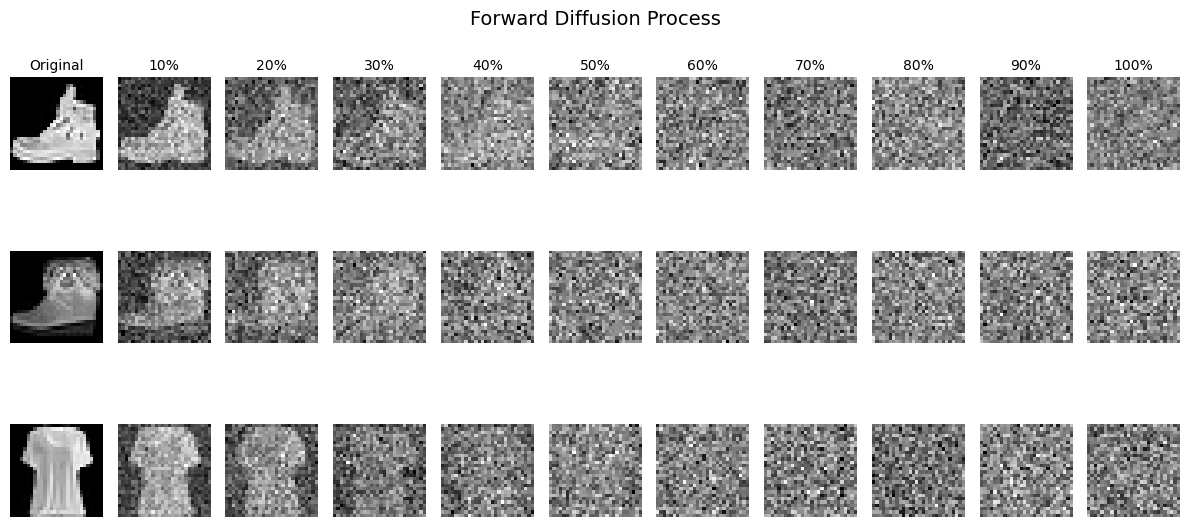

In [124]:
def show_forward_compact(ddpm, dataloader, device, n_images=6):
    """
    Visualize the forward diffusion process of the DDPM model.
    :param ddpm: The DDPM model instance.
    :param dataloader: DataLoader for the dataset.
    :param device: Device to run the model on (CPU or GPU).
    :param n_images: Number of images to visualize.
    """
    # Get a batch of images
    for batch in dataloader:
        imgs = batch[0][:n_images]
        break
    
    noise_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    n_cols = 1 + len(noise_percentages)
    
    fig, axes = plt.subplots(n_images, n_cols, figsize=(12, 2 * n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_images):
        # Original
        original_img = imgs[i].detach().cpu().numpy() if isinstance(imgs, torch.Tensor) else imgs[i]
        axes[i, 0].imshow(original_img[0], cmap='gray')
        axes[i, 0].set_title('Original' if i == 0 else '', fontsize=10)
        axes[i, 0].axis('off')
        
        # Noisy versions
        for j, percent in enumerate(noise_percentages):
            timestep = int(percent * ddpm.timesteps) - 1
            noisy_img = ddpm(imgs[i:i+1].to(device), [timestep])
            noisy_img = noisy_img.detach().cpu().numpy() if isinstance(noisy_img, torch.Tensor) else noisy_img
            
            axes[i, j+1].imshow(noisy_img[0][0], cmap='gray')
            if i == 0:  # Only show titles on first row
                axes[i, j+1].set_title(f'{int(percent * 100)}%', fontsize=10)
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Forward Diffusion Process', fontsize=14)
    plt.show()

show_forward_compact(ddpm, dataloader, device, n_images=3)

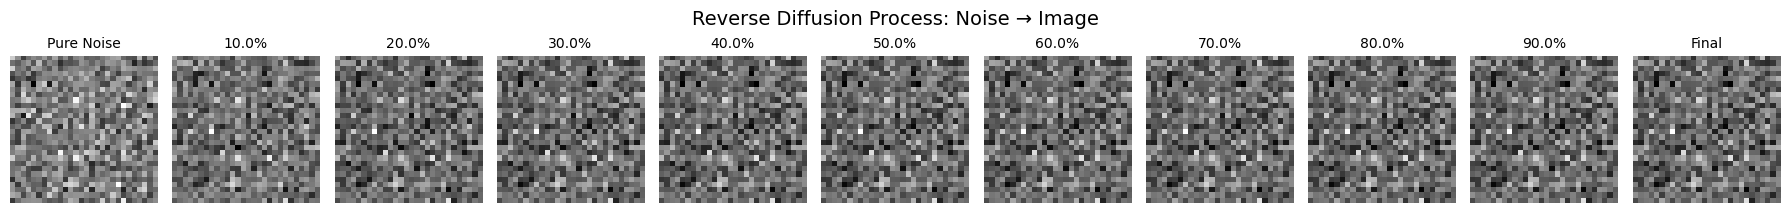

In [164]:
# Visualisze the reverse diffusion process (denoising) with the untrained DDPM model

def show_reverse_compact(ddpm, device, n_images=6, image_chw=(1, 28, 28)):
    """
    Visualize the reverse diffusion process of the DDPM model (denoising).
    Uses the same denoising logic as the working generate_new_images function.
    """
    
    # Define which timesteps to visualize (but still process all timesteps)
    noise_percentages = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]                   
    reversed_list = noise_percentages[::-1]
    timesteps_to_show = [int(p * ddpm.timesteps) for p in noise_percentages]
    timesteps_to_show = [min(t, ddpm.timesteps-1) for t in timesteps_to_show]  # Clamp to valid range
    
    n_cols = len(timesteps_to_show)
    
    fig, axes = plt.subplots(n_images, n_cols, figsize=(18, 2.5 * n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_images):
        
        # Start with pure random noise
        c, h, w = image_chw
        x = torch.randn(1, c, h, w).to(device)
        
        # Store images at visualization timesteps
        saved_images = {}
        
        with torch.no_grad():

            for t in range(ddpm.timesteps-1, -1, -1):  # Go from T-1 to 0 (or T to 1 in paper)
                
                # Save image if this timestep should be visualized
                if t in timesteps_to_show:
                    saved_images[t] = x.clone()
                
                # Perform denoising step

                if t > 0:  # Don't process t=0
                    
                    # Get model prediction - use same format as working code
                    time_tensor = (torch.ones(1, 1) * t).to(device).long()
                    noisy_prediction = ddpm.backward(x, time_tensor)
                    
                    alpha_t = ddpm.alphas[t]
                    alpha_t_bar = ddpm.alpha_bars[t]
                    
                    z = torch.randn_like(x)
                    beta_t = ddpm.betas[t]
                    sigma_t = beta_t.sqrt()

                    # Algorithm 2 in paper
                    x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * noisy_prediction) + sigma_t * z
                            
        # Save final result (t=0)
        saved_images[0] = x.clone()
        
        # Display saved images
        for col_idx, t in enumerate(timesteps_to_show):
            if t in saved_images:
                current_img = saved_images[t].detach().cpu().numpy()
            else:
                current_img = torch.zeros(1, c, h, w).numpy()  # Fallback
                
            axes[i, col_idx].imshow(current_img[0][0], cmap='gray')
            
            if i == 0:  # Only show titles on first row
                if t == ddpm.timesteps - 1:
                    axes[i, col_idx].set_title('Pure Noise', fontsize=10)
                elif t == 0:
                    axes[i, col_idx].set_title('Final', fontsize=10)
                else:
                    percentage = reversed_list[col_idx] * 100
                    axes[i, col_idx].set_title(f'{percentage}%', fontsize=10)
            axes[i, col_idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Reverse Diffusion Process: Noise → Image', fontsize=14)
    plt.show()

null_model = DDPM(UNet(n_steps=timesteps), timesteps=timesteps, device=device)

show_reverse_compact(null_model, device, n_images=1)

In [126]:
# Time to train the model on the data so it can generate more good looking images
# Defin traning loop

def training_loop(ddpm, dataloader, num_epochs, optim, device, weights_path):
    """
    Training loop for the DDPM model.
    :param ddpm: The DDPM model instance.
    :param loader: DataLoader for the dataset.
    :param num_epochs: Number of epochs to train.
    :param optim: Optimizer for training.
    :param device: Device to run the model on (CPU or GPU).
    :param weights_path: Path to save the model weights.
    """

    loss_fn = nn.MSELoss()
    best_loss = float('inf')
    timesteps = ddpm.timesteps

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(dataloader, leave=False, desc=f"Epoch {epoch + 1}/{num_epochs}")):

            x0 = batch[0].to(device)  # Get images from the batch
            n = len(x0)

            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, timesteps, (n,)).to(device)

            # Forward pass through the DDPM model
            x_noisy = ddpm(x0, t, eta)

            # Get model prediction of noise
            predicted_noise = ddpm.backward(x_noisy, t.reshape(n, -1))

            # Compuate loss
            loss = loss_fn(predicted_noise, eta)
    
            # Backward pass and optimization
            optim.zero_grad()
            loss.backward()
            optim.step()  

            # Update epoch loss after each batch
            epoch_loss += loss.item() * len(x0) / len(dataloader.dataset)

        # Save best model so far
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), weights_path)
            print(f"Epoch {epoch + 1}/{num_epochs} - New best loss: {best_loss:.4f} - Weights saved to {weights_path}")

In [143]:
# Train the DDPM model

# Hyperparamters for traning
weights_path = 'weights/weights.pth'
num_epochs = 20
learning_rate = 1e-3

# Traning loop
training_loop(ddpm, dataloader, num_epochs, Adam(ddpm.parameters(), lr=learning_rate), device, weights_path)

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

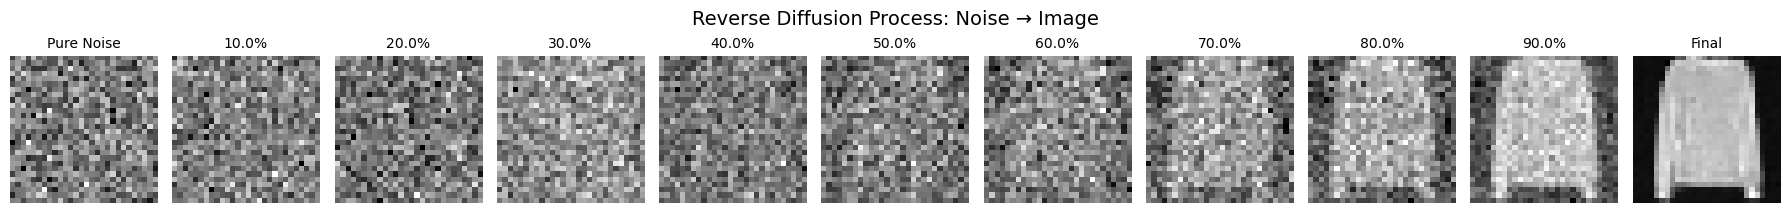

In [165]:

best_model = DDPM(UNet(n_steps=timesteps), timesteps=timesteps, device=device)
best_model.load_state_dict(torch.load(weights_path, map_location=device))
best_model.eval()
show_reverse_compact(best_model, device, n_images=1)